In [1]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/final_bigram_counts.p','rb')
final_bigram_counts=pickle.load(filename)
filename.close()

In [4]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/text_tf_idf.p','rb')
text_tf_idf=pickle.load(filename)
filename.close()

In [5]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/amazon_data.p','rb')
amazon_data=pickle.load(filename)
filename.close()

In [6]:
amazon_data.head()

,Score,Time,Text
138706,1,939340800,everi book educ witti littl book make son laug...
138683,1,940809600,whole seri great way spend time child rememb s...
417839,1,944092800,entertainingl funni beetlejuic well written mo...
417859,1,944438400,modern day fairi tale twist rumplestiskin capt...
417838,1,946857600,fantast beetlejuic excel funni movi keaton hil...


# Training on BOW data

## Time Based Splitting

In [7]:
#taking first 70% data_points as training data and rest as test_data
X_train_bow = final_bigram_counts[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_bow = final_bigram_counts[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper-Parameter Search

In [8]:
#importing required libraries 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import numpy as np
from tqdm.auto import tqdm

In [9]:
alpha_list=[1e-4,1e-3,1e-2,0.1,1,10,100,1000,10000]
cv_scores_bow=[]
for i in tqdm(alpha_list):
  clf=SGDClassifier(loss='log',penalty='l2',alpha=i)
  scores_bow = cross_val_score(clf, X_train_bow, y_train, cv=5, scoring='accuracy')
  cv_scores_bow.append(scores_bow.mean())

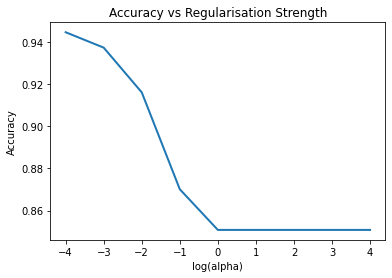

In [10]:
log_alpha=[-4,-3,-2,-1,0,1,2,3,4]
plt.ylabel('Accuracy')
plt.xlabel('log(alpha)')
plt.title('Accuracy vs Regularisation Strength')
plt.plot(log_alpha,cv_scores_bow,linewidth = 2.0 , linestyle="-")
plt.show()

In [11]:
optimal_alpha_bow = alpha_list[cv_scores_bow.index(max(cv_scores_bow))]
print("the optimal value for alpha is :{}".format(optimal_alpha_bow))

the optimal value for alpha is :0.0001


## Predict on test data with best hyper-parameters

In [12]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
LR_bow = SGDClassifier(loss='log',penalty='l2',alpha=optimal_alpha_bow)

#fitting the NB model
LR_bow.fit(X_train_bow,y_train)

#predicting for test_data 
LR_pred_bow = LR_bow.predict(X_test_bow)

LR_pred_train_bow = LR_bow.predict(X_train_bow)


#computing accuracy on test_data 
acc_LR_bow = accuracy_score(y_test,LR_pred_bow)*100
test_error_bow = (100-acc_LR_bow)
train_error_bow =( 1-accuracy_score(y_train,LR_pred_train_bow))*100
                  
                  
print("test accuracy using LR : {0:.2f}%" .format(round(acc_LR_bow,2)))
print("test error using LR : {0:.2f}%" .format(round(test_error_bow,2)))
print("train error using LR : {0:.2f}%" .format(round(train_error_bow,2)))

test accuracy using LR : 94.28%
test error using LR : 5.72%
train error using LR : 4.83%


In [13]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_bow = precision_score(y_test,LR_pred_bow)*100
recall_bow = recall_score(y_test,LR_pred_bow)*100
f1_bow = f1_score(y_test,LR_pred_bow)*100



def confusion_matrix_values(m, n):
    cm = confusion_matrix(m, n)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN, FN, FP, TP = confusion_matrix_values(y_test,LR_pred_bow)


print("precision score using LR classifier is : {0:.2f}%".format(round(precision_bow,2)))

print("Recall score using LR classifier is : {0:.2f}%" .format(round(recall_bow,2)))

print("F1-score using LR classifier is : {0:.2f}%".format(round(f1_bow,2)))

print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))


precision score using LR classifier is : 95.58%
Recall score using LR classifier is : 97.58%
F1-score using LR classifier is : 96.57%
True positive = 87993
False positive = 2182
False negative = 4068
True negative = 15009


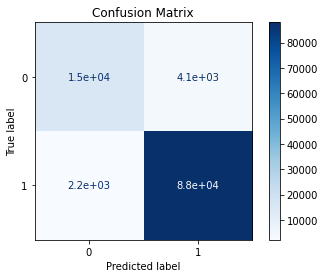

In [14]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR_bow, X_test_bow, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show() 

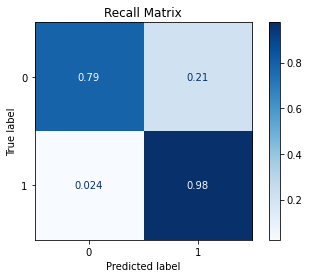

In [15]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

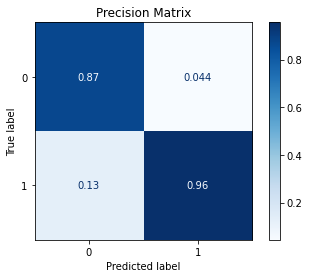

In [16]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='pred') 
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [17]:
#reporting the results in a table
from prettytable import PrettyTable

t= PrettyTable()

t.field_names =["metric/Parameter" , "result"]

t.add_row (["Model" ,"Classification"])
t.add_row (["Classifier" ,"LR"])
t.add_row  (["Optimal_alpha" , optimal_alpha_bow])
t.add_row(["test accuracy" ,round(acc_LR_bow,2)])
t.add_row (["Train_error" ,round(train_error_bow,2)])
t.add_row (["Test error" , round(test_error_bow,2)])

In [18]:
print(t)

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |       LR       |
|  Optimal_alpha   |     0.0001     |
|  test accuracy   |     94.28      |
|   Train_error    |      4.83      |
|    Test error    |      5.72      |
+------------------+----------------+


# Training on TFIDF Features

# Time Based Splitting

In [19]:
#taking first 70% data_points as training data and rest as test_data
X_train_tfidf = text_tf_idf[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_tfidf = text_tf_idf[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper-Parameter Search

In [20]:
alpha_list=[1e-4,1e-3,1e-2,0.1,1,10,100,1000,10000]
cv_scores_tfidf=[]
for i in tqdm(alpha_list):
  clf=SGDClassifier(loss='log',penalty='l2',alpha=i)
  scores_tfidf = cross_val_score(clf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
  cv_scores_tfidf.append(scores_tfidf.mean())

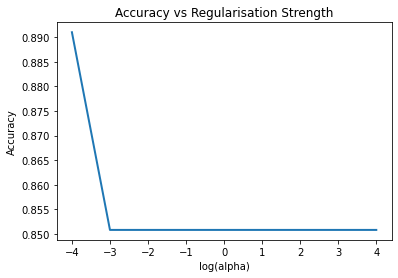

In [21]:
log_alpha=[-4,-3,-2,-1,0,1,2,3,4]
plt.ylabel('Accuracy')
plt.xlabel('log(alpha)')
plt.title('Accuracy vs Regularisation Strength')
plt.plot(log_alpha,cv_scores_tfidf,linewidth = 2.0 , linestyle="-")
plt.show()

In [22]:
optimal_alpha_tfidf = alpha_list[cv_scores_tfidf.index(max(cv_scores_tfidf))]
print("the optimal value for alpha is : {}".format(optimal_alpha_tfidf))

the optimal value for alpha is : 0.0001


## Predict on test data with best hyper-parameters

In [23]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
LR_tfidf = SGDClassifier(loss='log',penalty='l2',alpha=optimal_alpha_tfidf)

#fitting the NB model
LR_tfidf.fit(X_train_tfidf,y_train)

#predicting for test_data 
LR_pred_tfidf = LR_tfidf.predict(X_test_tfidf)

LR_pred_train_tfidf =LR_tfidf.predict(X_train_tfidf)


#computing accuracy on test_data 
acc_LR_tfidf = accuracy_score(y_test,LR_pred_tfidf)*100
test_error_tfidf = (100-acc_LR_tfidf)
train_error_tfidf =( 1-accuracy_score(y_train,LR_pred_train_tfidf))*100
                  
                  
print("test accuracy using NB : {0:.2f}%" .format(round(acc_LR_tfidf,2)))
print("test error using NB : {0:.2f}%" .format(round(test_error_tfidf,2)))
print("train error using NB : {0:.2f}%" .format(round(train_error_tfidf,2)))

test accuracy using NB : 87.71%
test error using NB : 12.29%
train error using NB : 10.74%


In [24]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_tfidf = precision_score(y_test,LR_pred_tfidf)*100
recall_tfidf = recall_score(y_test,LR_pred_tfidf)*100
f1_tfidf = f1_score(y_test,LR_pred_tfidf)*100



def confusion_matrix_values(v, u):
    cm = confusion_matrix(v, u)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN1, FN1, FP1, TP1 = confusion_matrix_values(y_test, LR_pred_tfidf)


print("precision score using LR classifier is : {0:.2f}%".format(round(precision_tfidf,2)))

print("Recall score using LR classifier is : {0:.2f}%" .format(round(recall_tfidf,2)))

print("F1-score using LR classifier is : {0:.2f}%".format(round(f1_tfidf,2)))

print('True positive = {}'.format(TP1))
print('False positive = {}'.format(FP1))
print('False negative = {}'.format(FN1))
print('True negative = {}'.format(TN1))


precision score using LR classifier is : 87.21%
Recall score using LR classifier is : 99.73%
F1-score using LR classifier is : 93.05%
True positive = 89934
False positive = 241
False negative = 13190
True negative = 5887


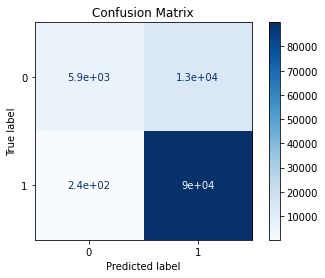

In [25]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show()

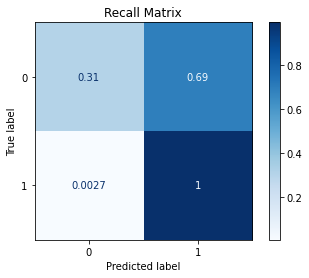

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

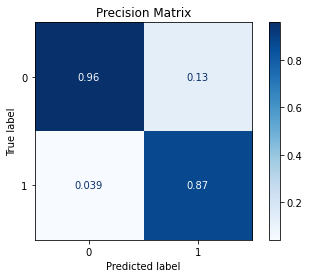

In [27]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='pred')  
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [28]:
#reporting the results in a table
from prettytable import PrettyTable

t1= PrettyTable()

t1.field_names =["metric/Parameter" , "result"]

t1.add_row(["Model" ,"Classification"])
t1.add_row (["Classifier" ,"LR"])
t1.add_row  (["Optimal_alpha" , optimal_alpha_tfidf])
t1.add_row(["test accuracy",round(acc_LR_tfidf,2)])
t1.add_row  (["Train_error" ,round(train_error_tfidf,2)])
t1.add_row  (["Test error" , round(test_error_tfidf,2)])

In [29]:
print(t1)

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |       LR       |
|  Optimal_alpha   |     0.0001     |
|  test accuracy   |     87.71      |
|   Train_error    |     10.74      |
|    Test error    |     12.29      |
+------------------+----------------+
